In [2]:
import pandas as pd
import numpy as np
import perception.util.conversion as conv
import os
import cv2
import scipy
import math
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

plt.style.use("seaborn-v0_8")

### Import and process BEV and tracking poses

In [3]:
experiments_dir = f'{os.getcwd()}/../../../../perception_debug'
run1_path = f'{experiments_dir}/run1'
run2_path = f'{experiments_dir}/run2'

bev_paths_run1 = [f'{run1_path}/bev/{f}' for f in os.listdir(f'{run1_path}/bev') if os.path.isdir(f'{run1_path}/bev/{f}')]
bev_paths_run2 = [f'{run2_path}/bev/{f}' for f in os.listdir(f'{run2_path}/bev') if os.path.isdir(f'{run2_path}/bev/{f}')]

tracking_paths_run1 = [f'{run1_path}/ego/{f}/color' for f in os.listdir(f'{run1_path}/ego') if os.path.isdir(f'{run1_path}/ego/{f}')]
tracking_paths_run2 = [f'{run2_path}/ego/{f}/color' for f in os.listdir(f'{run2_path}/ego') if os.path.isdir(f'{run2_path}/ego/{f}')]
# bev_path = f'{experiments_dir}/run/bev'
# ego_path = f'{experiments_dir}/50 expo-128 gain/color'
# bev_ego_pose_path = f'{bev_path}/ego_poses.csv'
# tracking_csv_path = f'{ego_path}/opp_rel_poses.csv'

def process_single_run(bev_path, ego_path, window_before_start_time=1, selected_bev_cam="right"):
  start_time = int(np.loadtxt(f'{bev_path}/start_time.txt')) / 1e9
 
  ego_pose_df = process_poses(
    pd.read_csv(f'{bev_path}/bev/{selected_bev_cam}/ego_poses.csv'), start_time, window_before_start_time)

  opp_pose_df = process_poses(
    pd.read_csv(f'{bev_path}/bev/{selected_bev_cam}/opp_poses.csv'), start_time, window_before_start_time)

  tracking_df = process_poses(
    pd.read_csv(f'{ego_path}/opp_rel_poses.csv'), start_time, window_before_start_time)
  
  last_bev_pose_time = max(ego_pose_df["time (sec)"].max(), opp_pose_df["time (sec)"].max())
  # Trim the tracking data to the last BEV pose time
  tracking_df = tracking_df[tracking_df["time (sec)"] <= last_bev_pose_time]

  return ego_pose_df, opp_pose_df, tracking_df

def process_all_runs(bev_paths, ego_paths, window_before_start_time=1):
  bev_run_data = []
  if len(bev_paths) != len(ego_paths):
    raise ValueError("The number of BEV and ego paths should be the same")

  for bev_path, ego_path in zip(bev_paths, ego_paths):
    start_time = int(np.loadtxt(f'{bev_path}/start_time.txt')) / 1e9
    ego_bev_right_df, opp_bev_right_df, tracking_df = process_single_run(bev_path, ego_path, window_before_start_time, selected_bev_cam="right")
    ego_bev_left_df, opp_bev_left_df, _ = process_single_run(bev_path, ego_path, window_before_start_time, selected_bev_cam="left")
    
    bev_run_data.append({
      "start_time": start_time,
      "bev_path": bev_path,
      "ego_path": ego_path,
      "ego_bev_right_df": ego_bev_right_df,
      "opp_bev_right_df": opp_bev_right_df,
      "ego_bev_left_df": ego_bev_left_df,
      "opp_bev_left_df": opp_bev_left_df,
      "tracking_df": tracking_df
    })
  return bev_run_data

def process_poses(poses_df: pd.DataFrame, start_time, window_before_start_time=1):
  poses_df["time (sec)"] = poses_df["time"] / 1e9
  
  # Include a few frames before the trajectory start time
  poses_df_start_time: pd.DataFrame = poses_df[poses_df["time (sec)"] > start_time]
  first_index = poses_df_start_time.index.min()

  if window_before_start_time >= 1:
    poses_df_start_time = pd.concat([poses_df.iloc[first_index - window_before_start_time:first_index], poses_df_start_time])

  poses_df_start_time = poses_df_start_time.reset_index(drop=True)

  # normalise the time from df to start at 0
  poses_df_start_time['time_norm (sec)'] = (poses_df_start_time['time (sec)'] - start_time)

  return poses_df_start_time

run1_data = process_all_runs(bev_paths_run1, tracking_paths_run1)
run2_data = process_all_runs(bev_paths_run2, tracking_paths_run2)

In [4]:
# TODO: Add uncertainty to these measurements
BEV_TO_BACK_OPP_X = -100.0
BEV_TO_BACK_OPP_Y = 0.0
BEV_TO_BACK_OPP_Z = -120.0

BEV_TO_CAM_EGO_X = -184.8
BEV_TO_CAM_EGO_Y = -39.5
BEV_TO_CAM_EGO_Z = 12.5

### Analyze single run for now

In [5]:
run_num = 7

combined_right_df = pd.concat([run1_data[run_num]["ego_bev_right_df"], run1_data[run_num]["opp_bev_right_df"]], axis=1, keys=['ego', 'opp'])
combined_left_df = pd.concat([run1_data[run_num]["ego_bev_left_df"], run1_data[run_num]["opp_bev_left_df"]], axis=1, keys=['ego', 'opp'])

# Drop rows with NaN values in any of the columns
combined_right_cleaned = combined_right_df.dropna().reset_index(drop=True)
combined_left_cleaned = combined_left_df.dropna().reset_index(drop=True)

ego_bev_right_df = combined_right_cleaned['ego']
opp_bev_right_df = combined_right_cleaned['opp']

ego_bev_left_df = combined_left_cleaned['ego']
opp_bev_left_df = combined_left_cleaned['opp']

tracking_df: pd.DataFrame = run1_data[run_num]["tracking_df"].dropna().reset_index(drop=True)

In [6]:
ego_bev_right_df.iloc[30:]

time        qx        qy        qz        qw        ax  \
30   1726384503283604306  0.970221  0.236692  0.047681  0.019378  3.010998   
31   1726384503300105044 -0.975215 -0.213466  0.051053  0.027971 -3.010342   
32   1726384503316638402  0.971828  0.234673 -0.021017  0.006073  3.041340   
33   1726384503333617660  0.972141  0.230349  0.037334  0.022101  3.011832   
34   1726384503350091724 -0.972666 -0.231451  0.018330  0.003867 -3.048221   
..                   ...       ...       ...       ...       ...       ...   
321  1726384508334112875 -0.999828  0.018251  0.003321  0.000613 -3.139827   
322  1726384508350660162 -0.999842  0.015401 -0.008532  0.002611 -3.135885   
323  1726384508368223472  0.999415 -0.026442 -0.018928  0.010577  3.118788   
324  1726384508384839112 -0.999860  0.016390 -0.003050  0.001375 -3.138406   
325  1726384508435098943 -0.999841  0.016264 -0.007278  0.001092 -3.138910   

           ay        az        tx        ty        tz    time (sec)  \
30   0.734552  0.147973  1.244733  1.067960  2.920204  1.726385e+09   
31  -0.658939  0.157594  1.275253  1.096693  3.011374  1.726385e+09   
32   0.734410 -0.065774  1.256531  1.085664  2.983554  1.726385e+09   
33   0.713653  0.115667  1.225595  1.061343  2.929511  1.726385e+09   
34  -0.725339  0.057443  1.241405  1.077610  2.987028  1.726385e+09   
..        ...       ...       ...       ...       ...           ...   
321  0.057314  0.010428 -0.860622  0.925751  2.967056  1.726385e+09   
322  0.048303 -0.026759 -0.862447  0.927022  2.972126  1.726385e+09   
323 -0.082515 -0.059066 -0.861645  0.924209  2.965081  1.726385e+09   
324  0.051445 -0.009573 -0.861689  0.926365  2.969629  1.726385e+09   
325  0.051058 -0.022850 -0.862560  0.927195  2.972268  1.726385e+09   

     time_norm (sec)  
30          0.484209  
31          0.500710  
32          0.517244  
33          0.534223  
34          0.550697  
..               ...  
321         5.534718  
322         5.551265  
323         5.568829  
324         5.585444  
325         5.635704  

[296 rows x 13 columns]

In [7]:
ego_bev_right_df.describe()

time          qx          qy          qz          qw  \
count  3.260000e+02  326.000000  326.000000  326.000000  326.000000   
mean   1.726385e+18    0.132226    0.019628   -0.002547    0.018726   
std    1.652698e+09    0.985881    0.108409    0.027199    0.018495   
min    1.726385e+18   -0.999890   -0.249970   -0.080263    0.000044   
25%    1.726385e+18   -0.999066   -0.021302   -0.019960    0.006669   
50%    1.726385e+18    0.971615    0.004043   -0.003973    0.012939   
75%    1.726385e+18    0.999011    0.027615    0.013631    0.024288   
max    1.726385e+18    0.999976    0.274382    0.152042    0.118451   

               ax          ay          az          tx          ty          tz  \
count  326.000000  326.000000  326.000000  326.000000  326.000000  326.000000   
mean     0.407972    0.061047   -0.007850    0.047761    0.957616    2.956695   
std      3.061803    0.338023    0.083553    0.801075    0.062192    0.028520   
min     -3.141017   -0.779445   -0.239225   -0.868615    0.903588    2.882476   
25%     -3.092842   -0.065581   -0.062449   -0.821589    0.924008    2.939602   
50%      3.008841    0.012331   -0.012462   -0.070828    0.928641    2.955440   
75%      3.103304    0.084530    0.042616    0.807367    0.950924    2.969278   
max      3.141072    0.858202    0.444681    1.373466    1.148748    3.116870   

         time (sec)  time_norm (sec)  
count  3.260000e+02       326.000000  
mean   1.726385e+09         2.811440  
std    1.652698e+00         1.652698  
min    1.726385e+09        -0.013628  
25%    1.726385e+09         1.339305  
50%    1.726385e+09         2.859380  
75%    1.726385e+09         4.247109  
max    1.726385e+09         5.635704

### Test difference with pose estimation on distorted and undistorted images

In [8]:
side_length = 0.15
half_side_length = side_length / 2

# Define the 4 corners of the ArUco marker
marker_obj_points = np.array([[
    [-half_side_length, half_side_length, 0],
    [half_side_length, half_side_length, 0],
    [half_side_length, -half_side_length, 0],
    [-half_side_length, -half_side_length, 0]
]], dtype=np.float32)

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
detector_params = cv2.aruco.DetectorParameters()
detector_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX

[[700.67498779   0.         628.23999023]
 [  0.         700.67498779 350.07598877]
 [  0.           0.           1.        ]]
[[541.27227994   0.         623.99757244]
 [  0.         539.36284999 348.98083539]
 [  0.           0.           1.        ]]


(array([[-0.27170633],
        [ 0.57701365],
        [ 2.75021666]]),
 (-158.92874941687847, 7.46021552515607, -178.34489426865932),
 array([[1.33016812],
        [1.10485384],
        [2.9063719 ]]),
 (164.33103609397807, 61.97254452409342, 20.807103624386674),
 array([[1.33016812],
        [1.10485384],
        [2.9063719 ]]),
 (164.33103609397807, 61.97254452409342, 20.807103624386674))

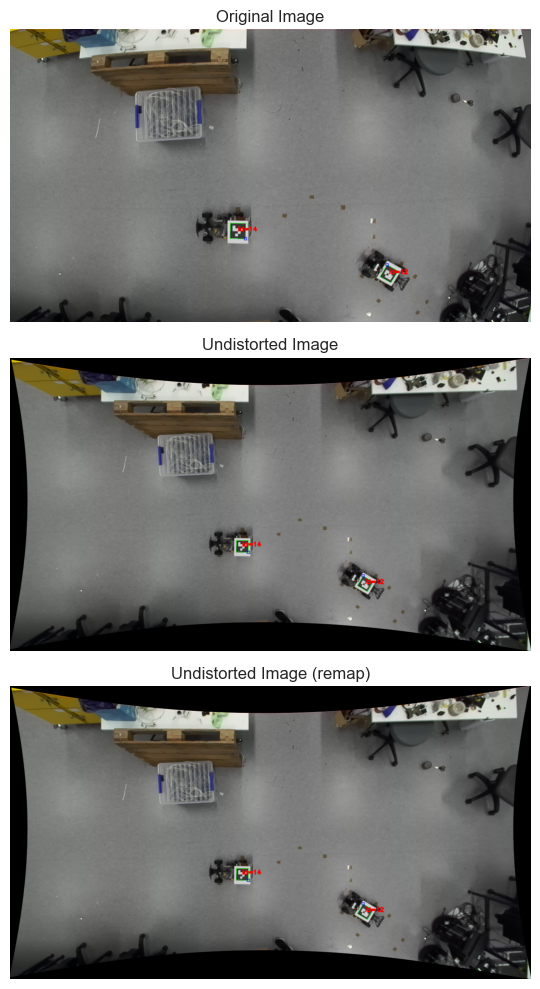

In [13]:
image = cv2.imread(f'{run1_path}/bev/24_09_15_18:50:11/bev/right/1726383014030341577.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

intrinsics = np.loadtxt(f'{run1_path}/bev/24_09_15_18:50:11/bev/right/intrinsics.txt')
dist_coeffs = np.loadtxt(f'{run1_path}/bev/24_09_15_18:50:11/bev/right/dist_coeffs.txt')

new_img_size = (int(image.shape[1] * 1.2), int(image.shape[0] * 1.2))
# not specifying new image size
new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
undistorted_image = cv2.undistort(image, intrinsics, dist_coeffs, None, new_intrinsics)

# specifying new image size
new_intrinsics2, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
mapx, mapy = cv2.initUndistortRectifyMap(intrinsics, dist_coeffs, None, new_intrinsics, image.shape[:2][::-1], m1type=cv2.CV_32FC1)
undistorted_image2 = cv2.remap(image, mapx, mapy, cv2.INTER_LINEAR)

und_corners, und_ids, _ = cv2.aruco.detectMarkers(undistorted_image, dictionary, parameters=detector_params)
und2_corners, und2_ids, _ = cv2.aruco.detectMarkers(undistorted_image2, dictionary, parameters=detector_params)
corners, ids, _ = cv2.aruco.detectMarkers(image, cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50), parameters=detector_params)

_, rvec_und, tvec_und = cv2.solvePnP(marker_obj_points, und_corners[0], new_intrinsics, None,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler_und = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec_und), degrees=True)

_, rvec_und2, tvec_und2 = cv2.solvePnP(marker_obj_points, und2_corners[0], new_intrinsics, None,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler_und2 = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec_und2), degrees=True)

_, rvec, tvec = cv2.solvePnP(marker_obj_points, corners[1], intrinsics, dist_coeffs,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec), degrees=True)

image_draw = cv2.aruco.drawDetectedMarkers(image.copy(), corners, ids)
und_image_draw = cv2.aruco.drawDetectedMarkers(undistorted_image.copy(), und_corners, und_ids)
und2_image_draw = cv2.aruco.drawDetectedMarkers(undistorted_image2.copy(), und2_corners, und2_ids)

plt.figure(figsize=(6, 10))
plt.subplot(3, 1, 1)
plt.grid(False)
plt.axis('off')
plt.imshow(image_draw)
plt.title("Original Image")
plt.subplot(3, 1, 2)
plt.grid(False)
plt.axis('off')
plt.imshow(und_image_draw)
plt.title("Undistorted Image")
plt.subplot(3, 1, 3)
plt.grid(False)
plt.axis('off')
plt.imshow(und2_image_draw)
plt.title("Undistorted Image (remap)")
plt.tight_layout()

print(intrinsics)
print(new_intrinsics)

tvec, euler, tvec_und, euler_und, tvec_und2, euler_und2

### Generate positive Euler angles following XYZ extrinsic convention

In [14]:
def stabilise_euler_angles(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
  """
  Stabilise the Euler angles by ensuring that the difference 
  between consecutive angles is less than 180 degrees
  """
  def find_closest_equiv_angle(alpha, beta):
    """
    Find the equivalent angle to alpha that is closest to beta
    """
    diff = beta - alpha
    if diff > 180:
      return alpha + 360
    elif diff < -180:
      return alpha - 360
    return alpha
  
  for i, row in df.iterrows():
    if i == 0:
      continue

    for col in cols:
      prev = df.loc[i - 1, col]
      curr = row[col]

      if abs(prev - curr) > 180:
        df.loc[i, col] = find_closest_equiv_angle(curr, prev) 

  for col in cols:
    df.loc[0, col] = find_closest_equiv_angle(df.loc[0, col], df.loc[1, col])  
    
  return df

In [15]:
ego_bev_right_df['roll'], ego_bev_right_df['pitch'], ego_bev_right_df['yaw'] = \
  zip(*ego_bev_right_df.apply(lambda row: conv.get_euler_from_quaternion(*row[['qx','qy','qz','qw']], degrees=True), axis=1))
opp_bev_right_df['roll'], opp_bev_right_df['pitch'], opp_bev_right_df['yaw'] = \
  zip(*opp_bev_right_df.apply(lambda row: conv.get_euler_from_quaternion(*row[['qx','qy','qz','qw']], degrees=True), axis=1))
tracking_df['roll'], tracking_df['pitch'], tracking_df['yaw'] = \
  zip(*tracking_df.apply(lambda row: conv.get_euler_from_quaternion(*row[['qx','qy','qz','qw']], degrees=True), axis=1))

ego_bev_right_df = stabilise_euler_angles(ego_bev_right_df, ['roll', 'pitch', 'yaw'])
opp_bev_right_df = stabilise_euler_angles(opp_bev_right_df, ['roll', 'pitch', 'yaw'])
tracking_df = stabilise_euler_angles(tracking_df, ['roll', 'pitch', 'yaw'])

/tmp/ipykernel_10756/4190472781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ego_bev_df['roll'], ego_bev_df['pitch'], ego_bev_df['yaw'] = \
/tmp/ipykernel_10756/4190472781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ego_bev_df['roll'], ego_bev_df['pitch'], ego_bev_df['yaw'] = \
/tmp/ipykernel_10756/4190472781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [16]:
opp_bev_right_df.describe()

time          qx          qy          qz          qw  \
count  3.260000e+02  326.000000  326.000000  326.000000  326.000000   
mean   1.726385e+18    0.008391   -0.183542    0.012181    0.015927   
std    1.652698e+09    0.070629    0.981300    0.025549    0.014842   
min    1.726385e+18   -0.106057   -0.999734   -0.058428    0.000055   
25%    1.726385e+18   -0.059637   -0.997341   -0.009701    0.004162   
50%    1.726385e+18    0.030110   -0.995121    0.014585    0.011561   
75%    1.726385e+18    0.070655    0.995701    0.027924    0.023414   
max    1.726385e+18    0.107483    0.999683    0.121990    0.071684   

               ax          ay          az          tx          ty          tz  \
count  326.000000  326.000000  326.000000  326.000000  326.000000  326.000000   
mean     0.025866   -0.567111    0.037573   -1.606211    0.504240    2.775923   
std      0.220539    3.053115    0.078947    0.794568    0.067183    0.024005   
min     -0.332942   -3.135698   -0.180686   -2.543836    0.412576    2.706611   
25%     -0.186246   -3.109782   -0.030011   -2.468673    0.423467    2.762434   
50%      0.093516   -3.070860    0.045435   -1.719369    0.517854    2.776280   
75%      0.218030    3.108152    0.087021   -0.873452    0.575068    2.788289   
max      0.335138    3.137508    0.372848   -0.271886    0.593010    2.893317   

         time (sec)  time_norm (sec)        roll       pitch         yaw  
count  3.260000e+02       326.000000  326.000000  326.000000  326.000000  
mean   1.726385e+09         2.811440  182.268584   -0.687478 -172.710778  
std    1.652698e+00         1.652698    2.248471    2.470851    3.605158  
min    1.726385e+09        -0.013628  173.789398   -8.337911 -180.454411  
25%    1.726385e+09         1.339305  181.327016   -2.146919 -175.787754  
50%    1.726385e+09         2.859380  182.013216   -0.497072 -172.443954  
75%    1.726385e+09         4.247109  183.206941    0.390770 -169.274614  
max    1.726385e+09         5.635704  194.032490    6.349488 -167.676271

### Sanity checking conversions

In [17]:
import importlib
importlib.reload(conv)

<module 'perception.util.conversion' from '/media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/build/perception/perception/util/conversion.py'>

In [18]:
rvec = ego_bev_right_df[["ax", "ay", "az"]].values[0]
euler = ego_bev_right_df[["roll", "pitch", "yaw"]].values[0]
quat = ego_bev_right_df[["qx", "qy", "qz", "qw"]].values[0]

print("rvecs")
print(rvec, conv.get_rodrigues_from_euler(*euler, degrees=True), sep="\n")

print("quats")
print(conv.get_quaternion_from_rodrigues(rvec), conv.get_quaternion_from_euler(*euler, degrees=True), sep="\n")

print("rotation matrices")
print(conv.get_rotation_matrix_from_quaternion(*quat), cv2.Rodrigues(rvec)[0], conv.get_rotation_matrix_from_euler(*euler, degrees=True), sep="\n")

print("euler angles")
print(conv.get_euler_from_quaternion(*quat), conv.get_euler_from_rotation_matrix(conv.get_rotation_matrix_from_quaternion(*quat)), sep="\n")

rvecs
[3.00763163 0.85820209 0.0102017 ]
[3.00763163 0.85820209 0.0102017 ]
quats
[0.96159025 0.27438159 0.00326166 0.00694982]
(0.9615902464286137, 0.2743815949209617, 0.003261655744270249, 0.00694981609778158)
rotation matrices
[[ 0.8494082   0.52764     0.01008656]
 [ 0.52773067 -0.84933288 -0.01157587]
 [ 0.00245895  0.01515563 -0.99988212]]
[[ 0.8494082   0.52764     0.01008656]
 [ 0.52773067 -0.84933288 -0.01157587]
 [ 0.00245895  0.01515563 -0.99988212]]
[[ 0.8494082   0.52764     0.01008656]
 [ 0.52773067 -0.84933288 -0.01157587]
 [ 0.00245895  0.01515563 -0.99988212]]
euler angles
(3.1264364001566607, -0.0024589519291482453, 0.5559285667648617)
(3.1264364001566607, -0.0024589519291482453, 0.5559285667648617)


In [19]:
# Make assumption that the top marker and the camera on the egovehicle have fixed relative orientation
EGO_TOP_MARKER_TO_EGO_CAM_QUAT = np.array([-0.5, -0.5, 0.5, 0.5])

### Get ground truth position of relative translation between egovehicle camera and opponent back marker

In [15]:
num = 50

ego_top_marker_to_bev_rvec = ego_bev_right_df.iloc[num][["ax", "ay", "az"]].to_numpy()
ego_top_marker_in_bev_frame = ego_bev_right_df.iloc[num][["tx", "ty", "tz"]].to_numpy()

opp_top_marker_to_bev_rvec = opp_bev_right_df.iloc[num][["ax", "ay", "az"]].to_numpy()
opp_top_marker_in_bev_frame = opp_bev_right_df.iloc[num][["tx", "ty", "tz"]].to_numpy()

def get_ego_cam_from_top_marker(rvec, tvec):
  """
  Get the position of the ego camera in the BEV camera frame
  """
  ego_cam_in_ego_top_marker_frame = np.array([BEV_TO_CAM_EGO_X, BEV_TO_CAM_EGO_Y, BEV_TO_CAM_EGO_Z]) / 1000
  ego_top_marker_to_bev_rot = cv2.Rodrigues(rvec)[0]

  ego_cam_in_ego_top_marker_frame_rot_to_ego_cam = ego_top_marker_to_bev_rot @ ego_cam_in_ego_top_marker_frame
  ego_top_marker_in_ego_cam_frame = tvec

  ego_cam_in_ego_cam_frame = ego_top_marker_in_ego_cam_frame + ego_cam_in_ego_top_marker_frame_rot_to_ego_cam
  return ego_cam_in_ego_cam_frame

def get_opp_back_from_top_marker(rvec, tvec):
  """
  Get the position of the opponent back marker in the BEV camera frame
  """
  opp_back_in_opp_top_marker_frame = np.array([BEV_TO_BACK_OPP_X, BEV_TO_BACK_OPP_Y, BEV_TO_BACK_OPP_Z]) / 1000
  opp_top_marker_to_bev_rot = cv2.Rodrigues(rvec)[0]

  opp_back_in_opp_top_marker_frame_rot_to_opp_back = opp_top_marker_to_bev_rot @ opp_back_in_opp_top_marker_frame
  opp_top_marker_in_opp_back_frame = tvec

  opp_back_in_opp_back_frame = opp_top_marker_in_opp_back_frame + opp_back_in_opp_top_marker_frame_rot_to_opp_back
  return opp_back_in_opp_back_frame

def rotate_bev_frame_to_ego_cam_frame(rvec, tvec):
  """
  Rotate the pose vector in the BEV frame to the ego camera frame
  """
  bev_to_ego_top_marker_rot = cv2.Rodrigues(rvec)[0].T
  
  return conv.get_rotation_matrix_from_quaternion(*EGO_TOP_MARKER_TO_EGO_CAM_QUAT).T @ bev_to_ego_top_marker_rot @ tvec

# Get position of ego camera in BEV frame
ego_cam_in_bev_frame = get_ego_cam_from_top_marker(ego_top_marker_to_bev_rvec, ego_top_marker_in_bev_frame)
# Get position of opponent back marker in BEV frame
opp_back_in_bev_frame = get_opp_back_from_top_marker(opp_top_marker_to_bev_rvec, opp_top_marker_in_bev_frame)

# Get the relative pose of the opponent back marker in the BEV camera frame
ground_truth_rel_pose_bev_frame = opp_back_in_bev_frame - ego_cam_in_bev_frame
# Convert the relative pose to the ego camera frame
print(ground_truth_rel_pose_bev_frame)
ground_truth_rel_pose_ego_cam_frame = rotate_bev_frame_to_ego_cam_frame(ego_top_marker_to_bev_rvec, ground_truth_rel_pose_bev_frame)

ground_truth_rel_pose_ego_cam_frame

[-1.4148242  -0.42471542 -0.23274802]


array([-0.2046834 , -0.43683688,  1.41547186])

In [16]:
ego_bev_right_df["ty"].rolling(window=20, min_periods=1, center=True).mean().iloc[30:]

30     1.091019
31     1.086640
32     1.081974
33     1.078476
34     1.074114
         ...   
321    0.925614
322    0.925757
323    0.925830
324    0.926055
325    0.926048
Name: ty, Length: 296, dtype: float64

In [17]:
from scipy.signal import savgol_filter

### apply exponential smoothing to the tracking data
# ego_bev_df['ty'].ewm(span=5).mean().plot()

def apply_rolling_mean(df: pd.DataFrame, src: str, dest: str, window=20, min_periods=1, center=True):
  df.loc[:, dest] = df[src].rolling(window=window, min_periods=min_periods, center=center).mean()

def apply_savgol_filter(df: pd.DataFrame, src: str, dest: str, window=20, polyorder=5):
  df.loc[:, dest] = savgol_filter(df[src], window, polyorder)

columns = ["tx", "ty", "tz", "roll", "pitch", "yaw"]

for col in columns:
  apply_rolling_mean(ego_bev_right_df, col, f"{col} (rolling)")
  apply_savgol_filter(ego_bev_right_df, col, f"{col} (savgol)", polyorder=2)

  apply_rolling_mean(opp_bev_right_df, col, f"{col} (rolling)")
  apply_savgol_filter(opp_bev_right_df, col, f"{col} (savgol)", polyorder=2)

stabilise_euler_angles(ego_bev_right_df, ["roll (rolling)", "pitch (rolling)", "yaw (rolling)"])
stabilise_euler_angles(opp_bev_right_df, ["roll (rolling)", "pitch (rolling)", "yaw (rolling)"])

stabilise_euler_angles(ego_bev_right_df, ["roll (savgol)", "pitch (savgol)", "yaw (savgol)"])
stabilise_euler_angles(opp_bev_right_df, ["roll (savgol)", "pitch (savgol)", "yaw (savgol)"])

ego_bev_right_df["ax (rolling)"], ego_bev_right_df["ay (rolling)"], ego_bev_right_df["az (rolling)"] = \
  zip(*ego_bev_right_df.apply(lambda row: conv.get_rodrigues_from_euler(*row[["roll (rolling)", "pitch (rolling)", "yaw (rolling)"]], degrees=True), axis=1))
opp_bev_right_df["ax (rolling)"], opp_bev_right_df["ay (rolling)"], opp_bev_right_df["az (rolling)"] = \
  zip(*opp_bev_right_df.apply(lambda row: conv.get_rodrigues_from_euler(*row[["roll (rolling)", "pitch (rolling)", "yaw (rolling)"]], degrees=True), axis=1))

ego_bev_right_df["ax (savgol)"], ego_bev_right_df["ay (savgol)"], ego_bev_right_df["az (savgol)"] = \
  zip(*ego_bev_right_df.apply(lambda row: conv.get_rodrigues_from_euler(*row[["roll (savgol)", "pitch (savgol)", "yaw (savgol)"]], degrees=True), axis=1))
opp_bev_right_df["ax (savgol)"], opp_bev_right_df["ay (savgol)"], opp_bev_right_df["az (savgol)"] = \
  zip(*opp_bev_right_df.apply(lambda row: conv.get_rodrigues_from_euler(*row[["roll (savgol)", "pitch (savgol)", "yaw (savgol)"]], degrees=True), axis=1))


/tmp/ipykernel_14918/4234516091.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, dest] = df[src].rolling(window=window, min_periods=min_periods, center=center).mean()
/tmp/ipykernel_14918/4234516091.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, dest] = savgol_filter(df[src], window, polyorder)
/tmp/ipykernel_14918/4234516091.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [39]:
ego_bev_right_df

time        qx        qy        qz        qw        ax  \
0    1726384502785766956  0.961590  0.274382  0.003262  0.006950  3.007632   
1    1726384502800483308  0.962539  0.270886 -0.009032  0.007601  3.009359   
2    1726384502816710353  0.962484  0.270819 -0.013278  0.010301  3.004061   
3    1726384502833403957  0.962250  0.272039 -0.004449  0.006987  3.009626   
4    1726384502850173537  0.962091  0.272583 -0.003367  0.008219  3.006786   
..                   ...       ...       ...       ...       ...       ...   
321  1726384508334112875 -0.999828  0.018251  0.003321  0.000613 -3.139827   
322  1726384508350660162 -0.999842  0.015401 -0.008532  0.002611 -3.135885   
323  1726384508368223472  0.999415 -0.026442 -0.018928  0.010577  3.118788   
324  1726384508384839112 -0.999860  0.016390 -0.003050  0.001375 -3.138406   
325  1726384508435098943 -0.999841  0.016264 -0.007278  0.001092 -3.138910   

           ay        az        tx        ty  ...  pitch (rolling)  \
0    0.858202  0.010202  1.350783  1.123419  ...         0.462718   
1    0.846919 -0.028240  1.359397  1.130045  ...         0.288066   
2    0.845268 -0.041442  1.362714  1.132672  ...         0.157015   
3    0.850857 -0.013917  1.355276  1.126894  ...         0.180793   
4    0.851893 -0.010524  1.353812  1.125892  ...         0.428682   
..        ...       ...       ...       ...  ...              ...   
321  0.057314  0.010428 -0.860622  0.925751  ...         0.834275   
322  0.048303 -0.026759 -0.862447  0.927022  ...         0.681945   
323 -0.082515 -0.059066 -0.861645  0.924209  ...         0.528010   
324  0.051445 -0.009573 -0.861689  0.926365  ...         0.355994   
325  0.051058 -0.022850 -0.862560  0.927195  ...         0.413587   

     pitch (savgol)  yaw (rolling)  yaw (savgol)  ax (rolling)  ay (rolling)  \
0          1.895644      31.453541     31.943067      3.004757      0.846235   
1          1.436336      31.443538     31.824116      3.004416      0.845816   
2          1.020118      31.377434     31.699011      3.005930      0.844333   
3          0.646988      31.191520     31.567752      3.010458      0.840335   
4          0.316946      30.920911     31.430339      3.017805      0.834722   
..              ...            ...           ...           ...           ...   
321        0.194781      -2.467037     -2.189286      3.133142     -0.067373   
322        0.056172      -2.404551     -2.129460      3.134509     -0.065722   
323       -0.080508      -2.331080     -2.070145      3.136011     -0.063766   
324       -0.215261      -2.251820     -2.011343      3.137119     -0.061636   
325       -0.348086      -2.279013     -1.953052      3.136686     -0.062366   

     az (rolling)  ax (savgol)  ay (savgol)  az (savgol)  
0       -0.004330     3.000218     0.859004    -0.044544  
1        0.000806     3.002107     0.856126    -0.031953  
2        0.004032     3.004031     0.853067    -0.020602  
3        0.001881     3.006002     0.849839    -0.010491  
4       -0.007622     3.008031     0.846450    -0.001621  
..            ...          ...          ...          ...  
321     -0.023079     3.138110    -0.059953    -0.005423  
322     -0.018871     3.139240    -0.058342    -0.001592  
323     -0.014612     3.140376    -0.056739     0.002187  
324     -0.009868    -3.140689     0.055130    -0.005913  
325     -0.011459    -3.139578     0.053507    -0.009581  

[326 rows x 34 columns]

In [18]:
opp_bev_right_df

time        qx        qy        qz        qw        ax  \
0    1726384502785766956 -0.012182  0.998614  0.029490  0.041860 -0.037285   
1    1726384502800483308 -0.014928  0.998952 -0.009632  0.042190 -0.045679   
2    1726384502816710353 -0.014922  0.998935 -0.003369  0.043521 -0.045623   
3    1726384502833403957 -0.006311  0.998857 -0.003947  0.047223 -0.019252   
4    1726384502850173537 -0.014426  0.998860 -0.007106  0.044954 -0.044068   
..                   ...       ...       ...       ...       ...       ...   
321  1726384508334112875 -0.102614  0.994592 -0.015620  0.003647 -0.321625   
322  1726384508350660162 -0.101617  0.994681 -0.016348  0.004176 -0.318393   
323  1726384508368223472 -0.102833  0.994573 -0.015017  0.005031 -0.322029   
324  1726384508384839112  0.102972 -0.994521  0.018030  0.000608  0.323371   
325  1726384508435098943 -0.101355  0.994731 -0.006696  0.013892 -0.315629   

           ay        az        tx        ty  ...  pitch (rolling)  \
0    3.056288  0.090256 -0.271886  0.577152  ...         4.944699   
1    3.056705 -0.029472 -0.273845  0.581987  ...         4.890859   
2    3.054165 -0.010299 -0.273724  0.581136  ...         4.856911   
3    3.047027 -0.012040 -0.273463  0.582750  ...         4.702824   
4    3.051259 -0.021708 -0.273738  0.581570  ...         4.762372   
..        ...       ...       ...       ...  ...              ...   
321  3.117370 -0.048958 -2.499991  0.418202  ...         0.132035   
322  3.116601 -0.051222 -2.501272  0.418497  ...         0.174964   
323  3.114574 -0.047026 -2.503537  0.418728  ...         0.230983   
324 -3.123169  0.056622 -2.493422  0.417255  ...         0.245538   
325  3.097700 -0.020851 -2.507258  0.419739  ...         0.293097   

     pitch (savgol)  yaw (rolling)  yaw (savgol)  ax (rolling)  ay (rolling)  \
0          3.593783    -178.713946   -178.744376     -0.034909      3.055163   
1          4.246726    -178.649965   -178.692769     -0.036706      3.056092   
2          4.788420    -178.674770   -178.652309     -0.036302      3.056692   
3          5.218867    -178.749281   -178.622997     -0.033677      3.059371   
4          5.538065    -178.731943   -178.604831     -0.033997      3.058312   
..              ...            ...           ...           ...           ...   
321        0.295471    -168.214765   -168.240993     -0.321879      3.119226   
322        0.410757    -168.224138   -168.255250     -0.321527      3.118498   
323        0.542032    -168.241661   -168.271441     -0.320932      3.117620   
324        0.689298    -168.251716   -168.289565     -0.320621      3.117357   
325        0.852552    -168.254778   -168.309623     -0.320447      3.116645   

     az (rolling)  ax (savgol)  ay (savgol)  az (savgol)  
0        0.015832    -0.033298     3.078568    -0.012852  
1        0.017926    -0.034977     3.067276     0.000882  
2        0.023893    -0.036399     3.057865     0.011890  
3        0.008280    -0.037502     3.050363     0.020209  
4        0.005090    -0.038237     3.044788     0.025869  
..            ...          ...          ...          ...  
321     -0.047503    -0.320824     3.116622    -0.045463  
322     -0.047612    -0.320199     3.114774    -0.043972  
323     -0.047056    -0.319492     3.112668    -0.042285  
324     -0.047563    -0.318705     3.110303    -0.040402  
325     -0.046213    -0.317837     3.107679    -0.038324  

[326 rows x 34 columns]

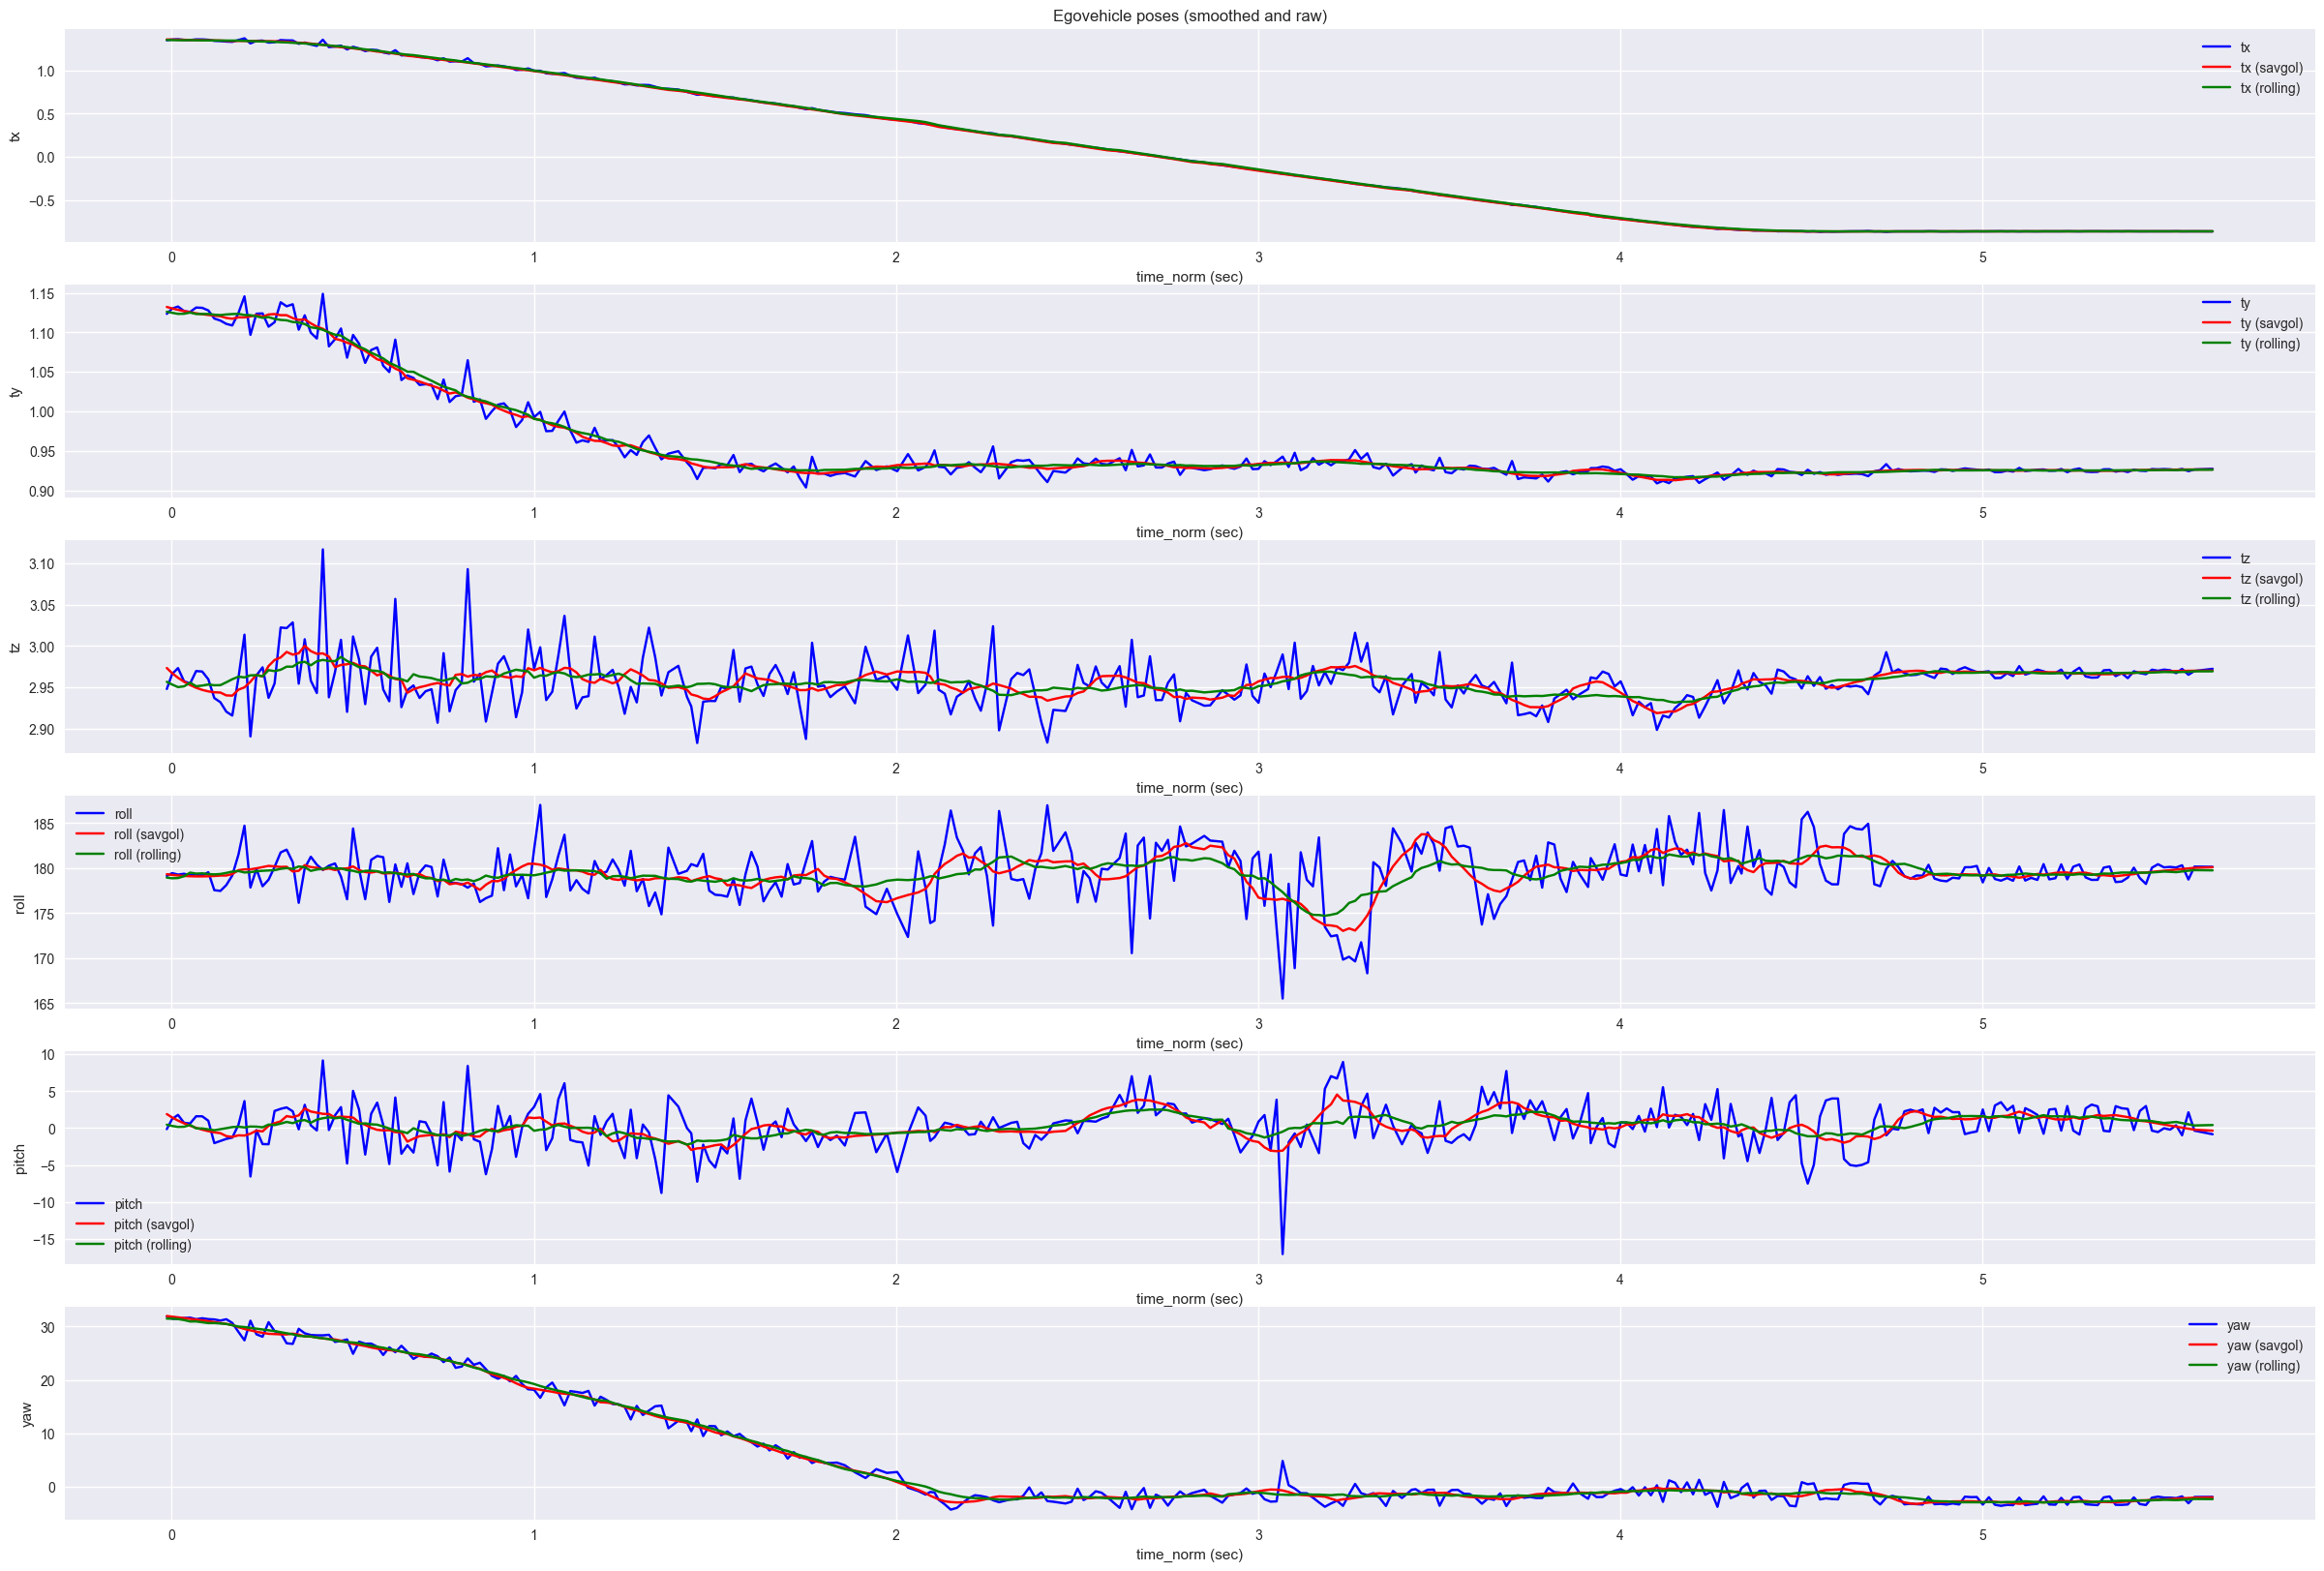

In [19]:
# plot the x and y positions
def plot_smoothed_data(df: pd.DataFrame, x_col: str, y_col: str):
  sns.lineplot(data=df, x=x_col, y=y_col, label=y_col, color='blue')
  sns.lineplot(data=df, x=x_col, y=f"{y_col} (savgol)", label=f"{y_col} (savgol)", color='red')
  sns.lineplot(data=df, x=x_col, y=f"{y_col} (rolling)", label=f"{y_col} (rolling)", color='green')

def plot_all_smoothed_poses(df: pd.DataFrame, columns: list[str], x_col: str):
  fig = plt.figure(figsize=(30, 20))
  for i, col in enumerate(columns):
    plt.subplot(len(columns), 1, i + 1)
    if i == 0:
      plt.title("Egovehicle poses (smoothed and raw)")
    plot_smoothed_data(df, x_col, col)

plot_all_smoothed_poses(ego_bev_right_df, ["tx", "ty", "tz", "roll", "pitch", "yaw"], "time_norm (sec)")

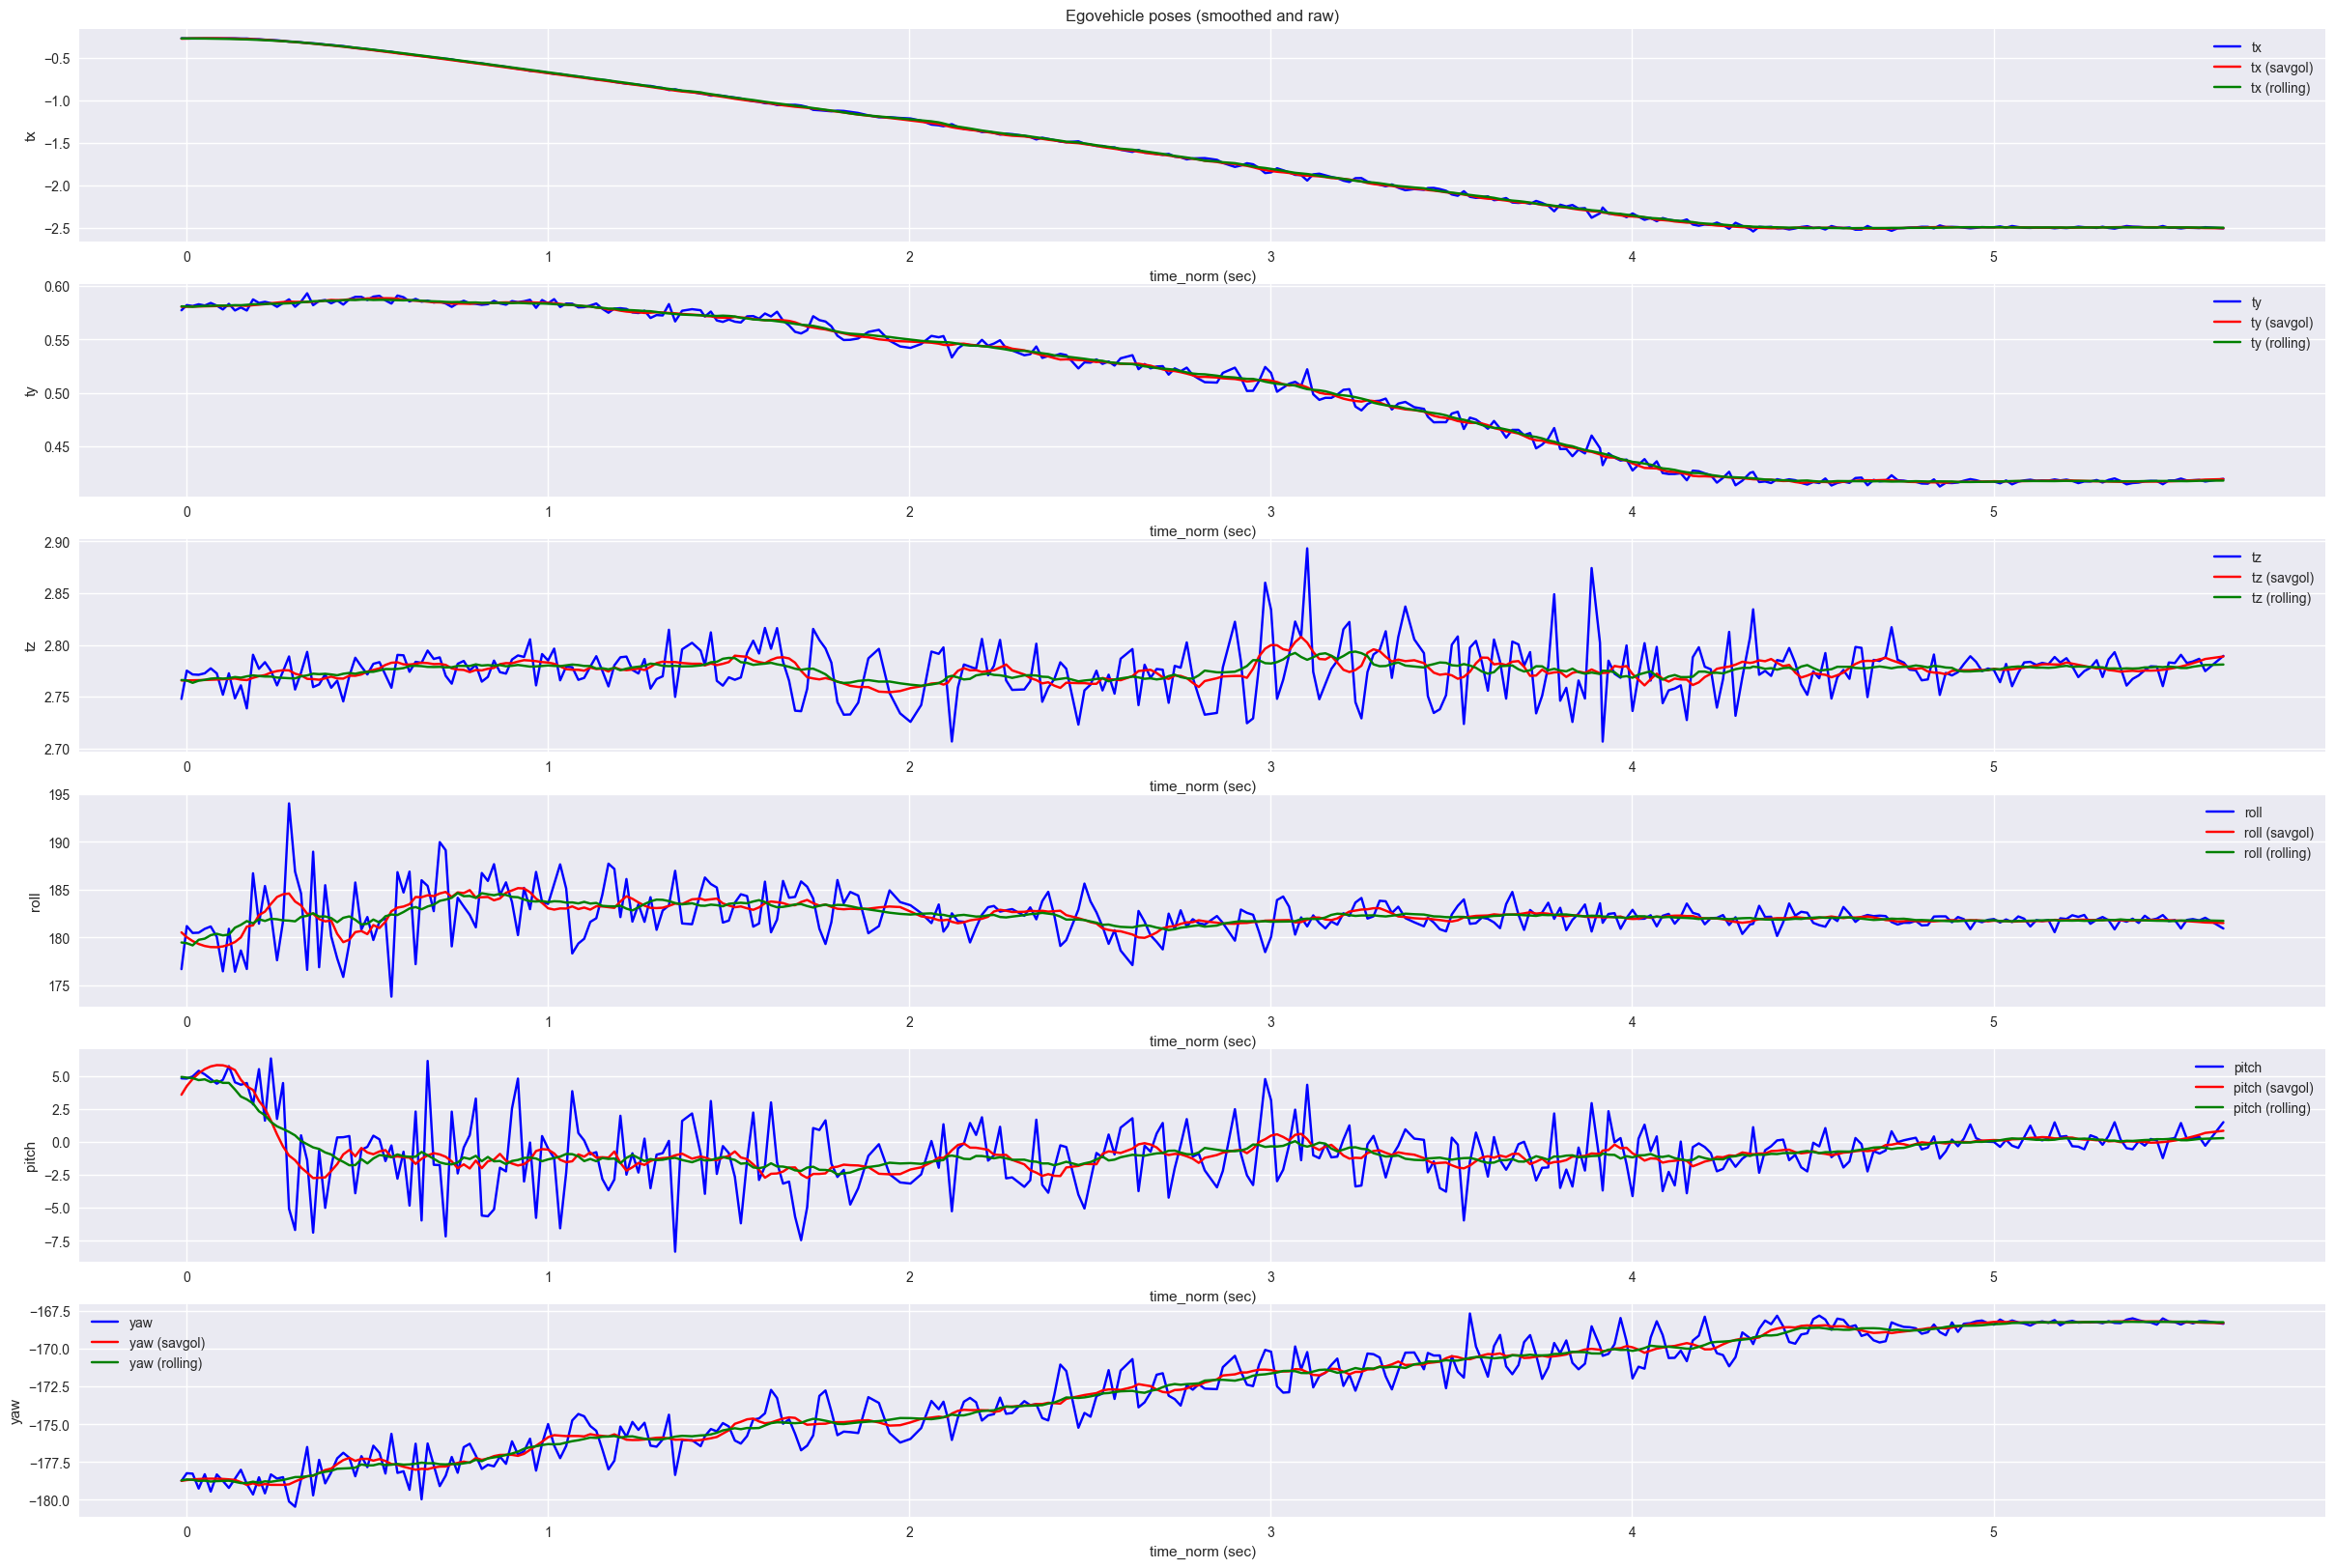

In [20]:
plot_all_smoothed_poses(opp_bev_right_df, ["tx", "ty", "tz", "roll", "pitch", "yaw"], "time_norm (sec)")

In [27]:
def compute_relative_pose(ego_bev_df: pd.DataFrame, opp_bev_df: pd.DataFrame):
  rel_poses = pd.DataFrame(columns=["time (sec)", "time_norm (sec)", "rel_x", "rel_y", "rel_z", "rel_roll", "rel_pitch", "rel_yaw"])

  for i in range(len(ego_bev_df)):
    ego_top_marker_to_bev_rvec = ego_bev_df.iloc[i][["ax (rolling)", "ay (rolling)", "az (rolling)"]].to_numpy()
    ego_top_marker_in_bev_frame = ego_bev_df.iloc[i][["tx (rolling)", "ty (rolling)", "tz (rolling)"]].to_numpy()

    opp_top_marker_to_bev_rvec = opp_bev_df.iloc[i][["ax (rolling)", "ay (rolling)", "az (rolling)"]].to_numpy()
    opp_top_marker_in_bev_frame = opp_bev_df.iloc[i][["tx (rolling)", "ty (rolling)", "tz (rolling)"]].to_numpy()

    # ego_top_marker_to_bev_rvec = ego_bev_df.iloc[i][["ax (savgol)", "ay (savgol)", "az (savgol)"]].to_numpy()
    # ego_top_marker_in_bev_frame = ego_bev_df.iloc[i][["tx (savgol)", "ty (savgol)", "tz (savgol)"]].to_numpy()

    # opp_top_marker_to_bev_rvec = opp_bev_df.iloc[i][["ax (savgol)", "ay (savgol)", "az (savgol)"]].to_numpy()
    # opp_top_marker_in_bev_frame = opp_bev_df.iloc[i][["tx (savgol)", "ty (savgol)", "tz (savgol)"]].to_numpy()

    ego_cam_in_bev_frame = get_ego_cam_from_top_marker(ego_top_marker_to_bev_rvec, ego_top_marker_in_bev_frame)
    opp_back_in_bev_frame = get_opp_back_from_top_marker(opp_top_marker_to_bev_rvec, opp_top_marker_in_bev_frame)

    ground_truth_rel_pose_bev_frame = opp_back_in_bev_frame - ego_cam_in_bev_frame
    ground_truth_rel_pose_ego_cam_frame = rotate_bev_frame_to_ego_cam_frame(ego_top_marker_to_bev_rvec, ground_truth_rel_pose_bev_frame)

    rel_poses = pd.concat([rel_poses, pd.DataFrame([{
      "time (sec)": ego_bev_df.loc[i, "time (sec)"],
      "time_norm (sec)": ego_bev_df.loc[i, "time_norm (sec)"],
      "rel_x": ground_truth_rel_pose_ego_cam_frame[0],
      "rel_y": ground_truth_rel_pose_ego_cam_frame[1],
      "rel_z": ground_truth_rel_pose_ego_cam_frame[2],
    }])])

  return rel_poses.reset_index(drop=True)

rel_pose_ground_truth_df = compute_relative_pose(ego_bev_right_df, opp_bev_right_df)

In [29]:
rel_pose_ground_truth_df[rel_pose_ground_truth_df["rel_y"] < -0.12]

time (sec)  time_norm (sec)     rel_x     rel_y     rel_z rel_roll  \
27  1.726385e+09         0.433996 -0.233211 -0.121319  1.423650      NaN   
29  1.726385e+09         0.467280 -0.226315 -0.125000  1.426963      NaN   

   rel_pitch rel_yaw  
27       NaN     NaN  
29       NaN     NaN

In [35]:
ego_bev_right_df[ego_bev_right_df["time_norm (sec)"] > 0.433][["roll", "pitch", "yaw"]]

roll     pitch        yaw
27   180.265159 -0.251791  28.428897
28   180.514603  1.714470  27.108591
29   179.060778  2.834808  27.288026
30   176.538144 -4.781042  27.564319
31   184.395824  5.027532  24.886736
..          ...       ...        ...
321  180.063232  0.381734  -2.091295
322  180.314206 -0.972944  -1.767604
323  178.730373  2.136145  -3.054743
324  180.163292 -0.346864  -1.878734
325  180.138699 -0.831896  -1.864822

[299 rows x 3 columns]

In [36]:
opp_bev_right_df[opp_bev_right_df["time_norm (sec)"] > 0.433][["roll", "pitch", "yaw"]]

roll     pitch         yaw
27   175.856135  0.360531 -176.886044
28   179.400597  0.452718 -177.216930
29   185.744873 -3.895811 -178.439974
30   180.815658 -0.591615 -177.109896
31   182.128761 -0.368676 -177.835313
..          ...       ...         ...
321  181.823452  0.231941 -168.215349
322  181.912352  0.285599 -168.329004
323  181.771057  0.396405 -168.187731
324  182.048072 -0.282083 -168.182421
325  180.924910  1.505885 -168.352105

[299 rows x 3 columns]

<AxesSubplot: xlabel='time_norm (sec)', ylabel='rel_z'>

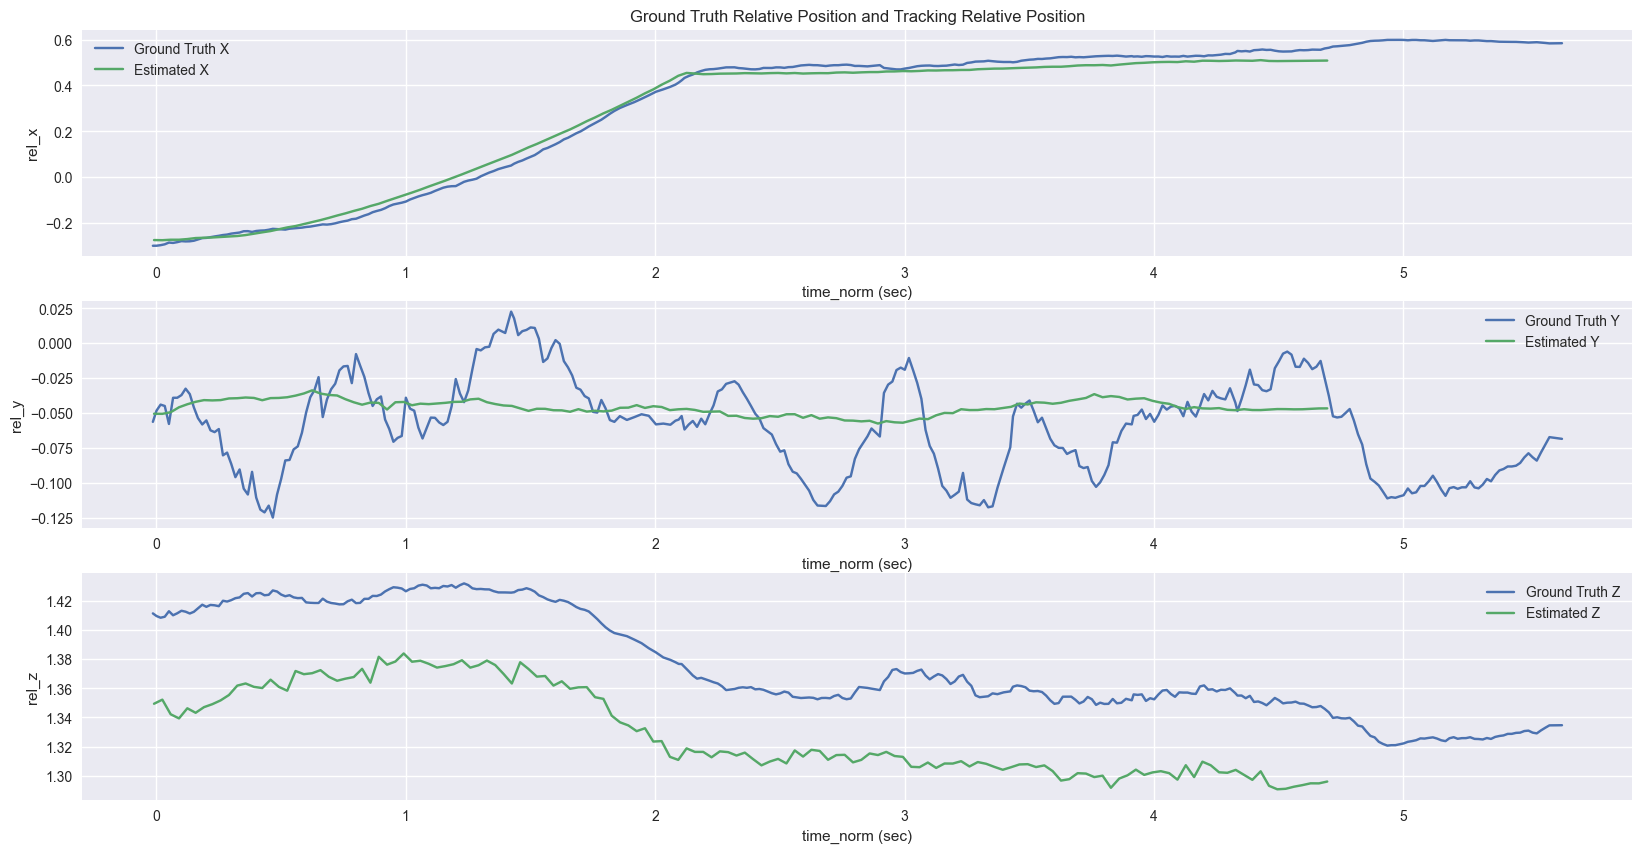

In [22]:
# plot the x and y positions
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title("Ground Truth Relative Position and Tracking Relative Position")

sns.lineplot(x="time_norm (sec)", y="rel_x", data=rel_pose_ground_truth_df, label="Ground Truth X")
sns.lineplot(x="time_norm (sec)", y="tx", data=tracking_df, label="Estimated X")

ax = plt.subplot(3, 1, 2)
# ax.set_ylim(-0.5, 0.5)
sns.lineplot(x="time_norm (sec)", y="rel_y", data=rel_pose_ground_truth_df, label="Ground Truth Y")
sns.lineplot(x="time_norm (sec)", y="ty", data=tracking_df, label="Estimated Y")

plt.subplot(3, 1, 3)
sns.lineplot(x="time_norm (sec)", y="rel_z", data=rel_pose_ground_truth_df, label="Ground Truth Z")
sns.lineplot(x="time_norm (sec)", y="tz", data=tracking_df, label="Estimated Z")

In [175]:
from numpy.polynomial.polynomial import Polynomial

degree = 10
CONFIDENCE_INTERVAL = 0.95

def fit_model(df: pd.DataFrame, x_col: str, y_col: str, degree=1, confidence_interval=0.95):
  model: Polynomial = Polynomial.fit(df[x_col], df[y_col], degree)
  preds = model(df[x_col])
  residuals = df[y_col] - preds
  se = np.sqrt(sum(residuals ** 2) / (len(residuals) - degree - 1))
  z_score = stats.norm.ppf(1 - (1 - confidence_interval) / 2)
  confidence = z_score * se

  # get R-squared value
  ss_res = sum(residuals ** 2)
  ss_tot = sum((df[y_col] - np.mean(df[y_col])) ** 2)
  r_squared = 1 - (ss_res / ss_tot)

  return model, residuals, confidence, r_squared

tx_model, _, tx_confidence, tx_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "tx", degree, CONFIDENCE_INTERVAL)
ty_model, _, ty_confidence, ty_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "ty", degree, CONFIDENCE_INTERVAL)
tz_model, _, tz_confidence, tz_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "tz", degree, CONFIDENCE_INTERVAL)

tx_rolling_model, _, tx_rolling_confidence, tx_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "tx (rolling)", degree, CONFIDENCE_INTERVAL)
ty_rolling_model, _, ty_rolling_confidence, ty_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "ty (rolling)", degree, CONFIDENCE_INTERVAL)
tz_rolling_model, _, tz_rolling_confidence, tz_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "tz (rolling)", degree, CONFIDENCE_INTERVAL)

pitch_rolling_model, _, pitch_rolling_confidence, pitch_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "pitch (rolling)", degree, CONFIDENCE_INTERVAL)
roll_rolling_model, _, roll_rolling_confidence, roll_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "roll (rolling)", degree, CONFIDENCE_INTERVAL)
yaw_rolling_model, _, yaw_rolling_confidence, yaw_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "yaw (rolling)", degree, CONFIDENCE_INTERVAL)

rel_x_model, _, rel_x_confidence, rel_x_r2 = fit_model(rel_pose_ground_truth_df, "time_norm (sec)", "rel_x", degree, CONFIDENCE_INTERVAL)
rel_y_model, _, rel_y_confidence, rel_y_r2 = fit_model(rel_pose_ground_truth_df, "time_norm (sec)", "rel_y", 1, CONFIDENCE_INTERVAL)
rel_z_model, _, rel_z_confidence, rel_z_r2 = fit_model(rel_pose_ground_truth_df, "time_norm (sec)", "rel_z", degree, CONFIDENCE_INTERVAL)

In [23]:
z_tx: pd.Series = stats.zscore(ego_bev_right_df['tx'])
z_tx = z_tx.apply(lambda x: abs(x))

z_ty: pd.Series = stats.zscore(ego_bev_right_df['ty'])
z_ty = z_ty.apply(lambda x: abs(x))

z_tz: pd.Series = stats.zscore(ego_bev_right_df['tz'])
z_tz = z_tz.apply(lambda x: abs(x))

# get all the unique indexes of the outliers
outliers = pd.concat((z_tx[z_tx > 3], z_ty[z_ty > 3], z_tz[z_tz > 3])).index.unique()
ego_bev_right_df.iloc[outliers]

time        qx        qy        qz        qw        ax  \
13  1726384503000215531 -0.970541 -0.235273  0.040643  0.032320 -2.987859   
26  1726384503216653275  0.966477  0.244072 -0.076835  0.021178  2.996009   
38  1726384503416715822  0.975348  0.217677 -0.035965  0.004381  3.055630   
50  1726384503616707593  0.975022  0.208830 -0.067680  0.033792  2.998926   

          ay        az        tx        ty  ...  pitch (rolling)  \
13 -0.724300  0.125121  1.373466  1.145538  ...         0.089318   
26  0.756605 -0.238184  1.357050  1.148748  ...         1.333311   
38  0.681953 -0.112672  1.235737  1.090744  ...        -0.339138   
50  0.642310 -0.208168  1.143065  1.064671  ...        -0.892107   

    pitch (savgol)  yaw (rolling)  yaw (savgol)  ax (rolling)  ay (rolling)  \
13       -1.007061      29.884156     29.525375      3.027032      0.807823   
26        1.925594      27.793490     27.749602      3.042612      0.752815   
38       -0.545405      25.552673     25.454695      3.055682      0.692860   
50       -0.829266      22.661855     22.789048      3.062012      0.613295   

    az (rolling)  ax (savgol)  ay (savgol)  az (savgol)  
13      0.001077    -3.035775    -0.799936    -0.027676  
26     -0.034842     3.038984     0.750732    -0.049991  
38      0.012464     3.057595     0.690521     0.017754  
50      0.030620     3.055386     0.615447     0.030763  

[4 rows x 34 columns]

In [67]:
# rotate the rvec 90 degrees anticlockwise around the z axis
def rotate_rvec_90(rvec):
    R = cv2.Rodrigues(rvec)[0]
    R_rot = np.array([
        [0, 1, 0],
        [-1, 0, 0],
        [0, 0, 1]
    ])
    R_rotated = R @ R_rot
    return cv2.Rodrigues(R_rotated)[0]

In [20]:
from numpy.polynomial.polynomial import Polynomial

degree = 10
CONFIDENCE_INTERVAL = 0.95

tx_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['tx'], degree)
ty_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['ty'], degree)
tz_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['tz'], 1)

In [21]:
tz_model.coef

array([ 2.95669578e+00, -2.42429130e-03])

In [22]:
tx_preds = tx_model(ego_bev_right_df['time_norm (sec)'])
ty_preds = ty_model(ego_bev_right_df['time_norm (sec)'])
tz_preds = tz_model(ego_bev_right_df['time_norm (sec)'])

tx_residuals = ego_bev_right_df['tx'] - tx_preds
ty_residuals = ego_bev_right_df['ty'] - ty_preds
tz_residuals = ego_bev_right_df['tz'] - tz_preds

# Standard error of the residuals
tx_se = np.sqrt(sum(tx_residuals ** 2) / (len(tx_residuals) - degree - 1))
ty_se = np.sqrt(sum(ty_residuals ** 2) / (len(ty_residuals) - degree - 1))
tz_se = np.sqrt(sum(tz_residuals ** 2) / (len(tz_residuals) - degree - 1))

z_score = stats.norm.ppf(1 - (1 - CONFIDENCE_INTERVAL) / 2)

# (tx_residuals.sum() / (len(tx_residuals) - degree-1))
# tx_se = np.std(tx_residuals)

tx_confidence = z_score * tx_se
ty_confidence = z_score * ty_se
tz_confidence = z_score * tz_se

tx_confidence, ty_confidence, tz_confidence

(0.019255782491731294, 0.018270740355279216, 0.05670819452096364)

<AxesSubplot: xlabel='time_norm (sec)'>

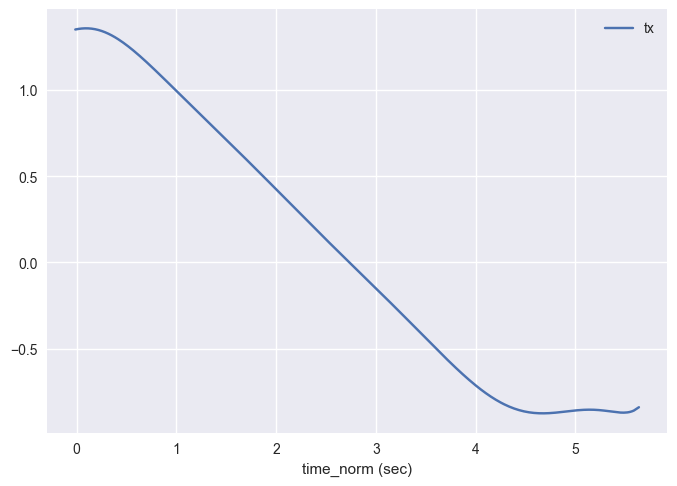

In [23]:
pd.DataFrame(np.vstack((ego_bev_right_df["time_norm (sec)"].values, tx_preds)).T, columns=["time_norm (sec)", "tx"]).plot(x="time_norm (sec)", y="tx")

<AxesSubplot: xlabel='time_norm (sec)', ylabel='tz'>

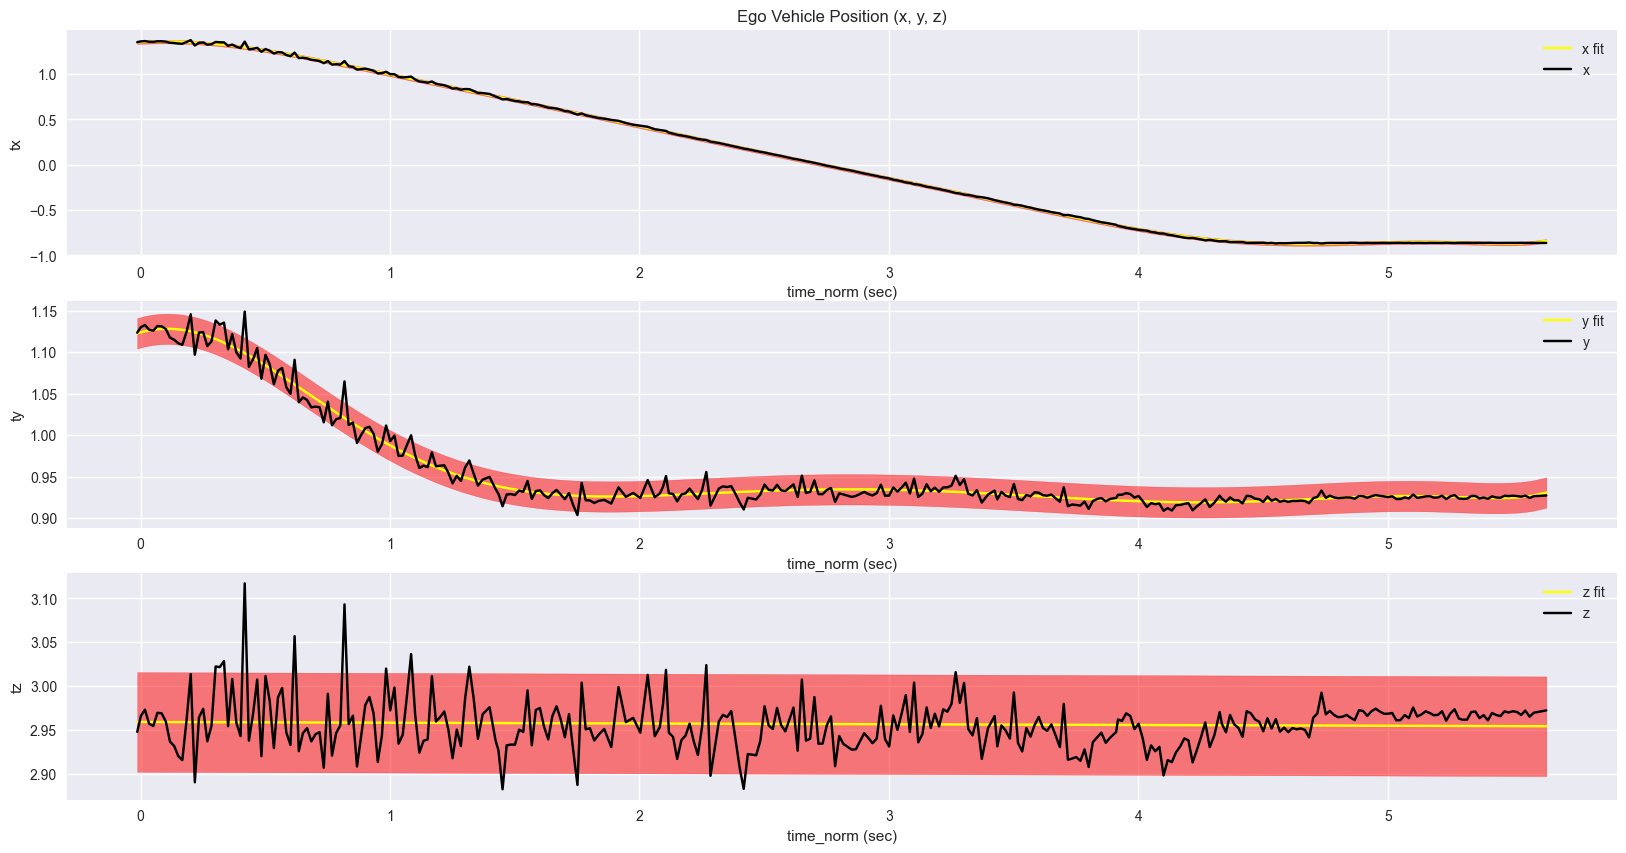

In [24]:
# plot the x and y positions
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title('Ego Vehicle Position (x, y, z)')
# plot the polynomial fit
plt.plot(ego_bev_right_df['time_norm (sec)'], tx_preds, label='x fit', markersize='5', color='yellow')
# show the confidence interval
plt.fill_between(ego_bev_right_df['time_norm (sec)'], tx_preds - tx_confidence, 
                    tx_preds + tx_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='tx', label='x', color='black')

plt.subplot(3, 1, 2)
plt.plot(ego_bev_right_df['time_norm (sec)'], ty_preds, label='y fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_right_df['time_norm (sec)'], ty_preds - ty_confidence, 
                 ty_preds + ty_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='ty', label='y', color='black')

plt.subplot(3, 1, 3)
plt.plot(ego_bev_right_df['time_norm (sec)'], tz_preds, label='z fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_right_df['time_norm (sec)'], tz_preds - tz_confidence, 
                 tz_preds + tz_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='tz', label='z', color='black')

<AxesSubplot: xlabel='time_norm (sec)', ylabel='tz'>

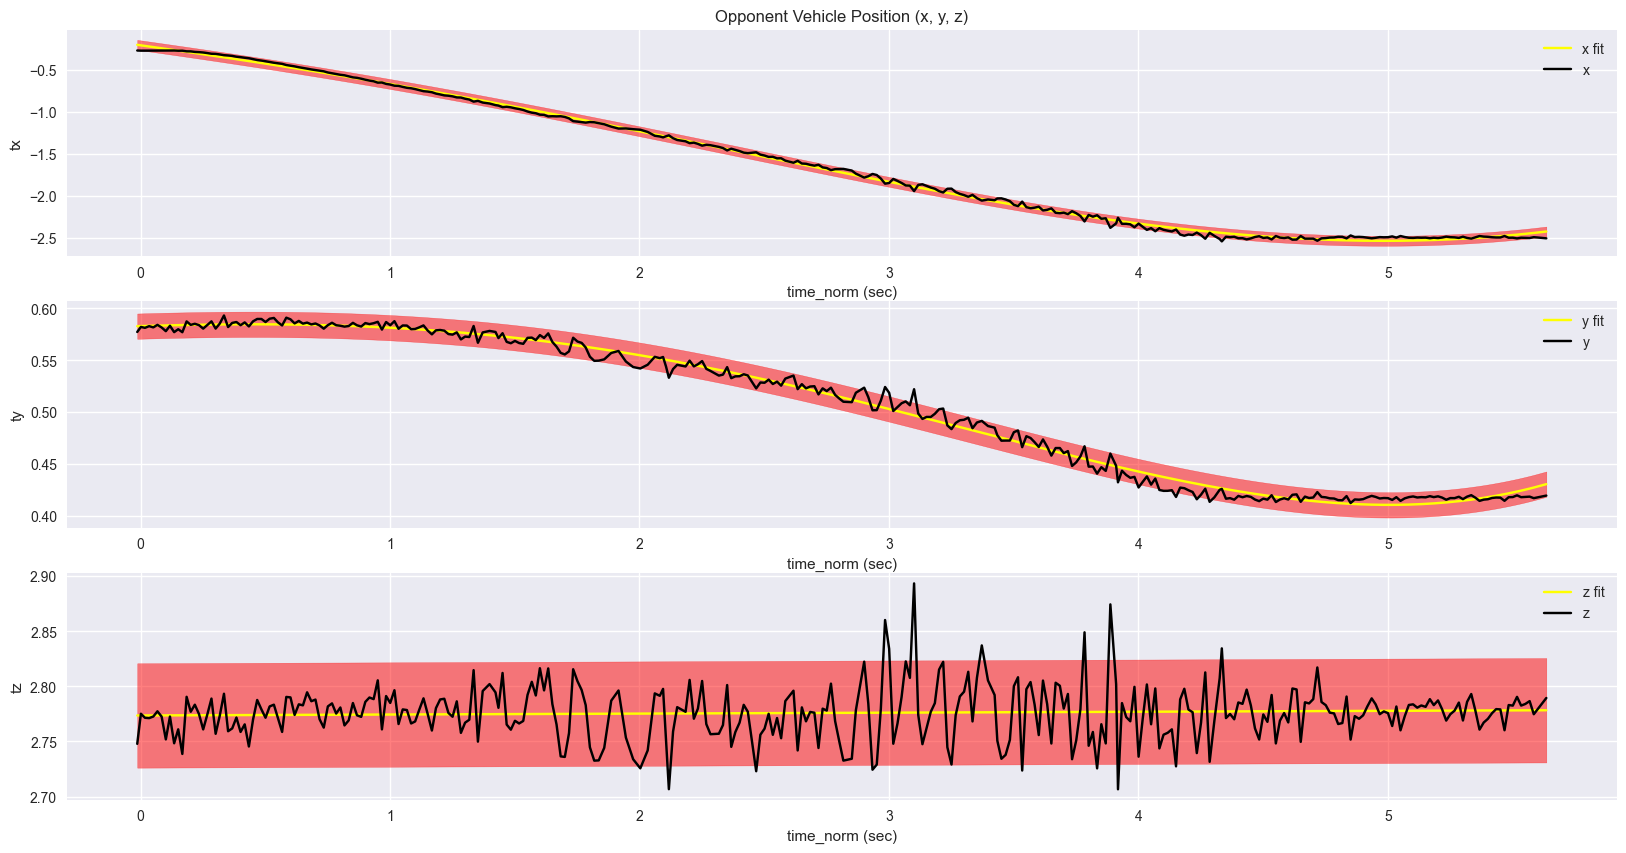

In [26]:
# plot the same for opp_bev_df
tx_model_opp: Polynomial = Polynomial.fit(opp_bev_right_df['time_norm (sec)'], opp_bev_right_df['tx'], degree)
ty_model_opp: Polynomial = Polynomial.fit(opp_bev_right_df['time_norm (sec)'], opp_bev_right_df['ty'], degree)
tz_model_opp: Polynomial = Polynomial.fit(opp_bev_right_df['time_norm (sec)'], opp_bev_right_df['tz'], 1)

tx_preds_opp = tx_model_opp(opp_bev_right_df['time_norm (sec)'])
ty_preds_opp = ty_model_opp(opp_bev_right_df['time_norm (sec)'])
tz_preds_opp = tz_model_opp(opp_bev_right_df['time_norm (sec)'])

tx_residuals_opp = opp_bev_right_df['tx'] - tx_preds_opp
ty_residuals_opp = opp_bev_right_df['ty'] - ty_preds_opp
tz_residuals_opp = opp_bev_right_df['tz'] - tz_preds_opp

tx_se_opp = np.sqrt(sum(tx_residuals_opp ** 2) / (len(tx_residuals_opp) - degree - 1))
ty_se_opp = np.sqrt(sum(ty_residuals_opp ** 2) / (len(ty_residuals_opp) - degree - 1))
tz_se_opp = np.sqrt(sum(tz_residuals_opp ** 2) / (len(tz_residuals_opp) - degree - 1))

tx_confidence_opp = z_score * tx_se_opp
ty_confidence_opp = z_score * ty_se_opp
tz_confidence_opp = z_score * tz_se_opp

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title('Opponent Vehicle Position (x, y, z)')
plt.plot(opp_bev_right_df['time_norm (sec)'], tx_preds_opp, label='x fit', markersize='5', color='yellow')

plt.fill_between(opp_bev_right_df['time_norm (sec)'], tx_preds_opp - tx_confidence_opp,
                  tx_preds_opp + tx_confidence_opp, alpha=0.5, color='red')
sns.lineplot(data=opp_bev_right_df, x='time_norm (sec)', y='tx', label='x', color='black')

plt.subplot(3, 1, 2)
plt.plot(opp_bev_right_df['time_norm (sec)'], ty_preds_opp, label='y fit', markersize='5', color='yellow')
plt.fill_between(opp_bev_right_df['time_norm (sec)'], ty_preds_opp - ty_confidence_opp,
                 ty_preds_opp + ty_confidence_opp, alpha=0.5, color='red')
sns.lineplot(data=opp_bev_right_df, x='time_norm (sec)', y='ty', label='y', color='black')

plt.subplot(3, 1, 3)
plt.plot(opp_bev_right_df['time_norm (sec)'], tz_preds_opp, label='z fit', markersize='5', color='yellow')
plt.fill_between(opp_bev_right_df['time_norm (sec)'], tz_preds_opp - tz_confidence_opp,
                 tz_preds_opp + tz_confidence_opp, alpha=0.5, color='red')
sns.lineplot(data=opp_bev_right_df, x='time_norm (sec)', y='tz', label='z', color='black')

<AxesSubplot: xlabel='time_norm (sec)', ylabel='yaw'>

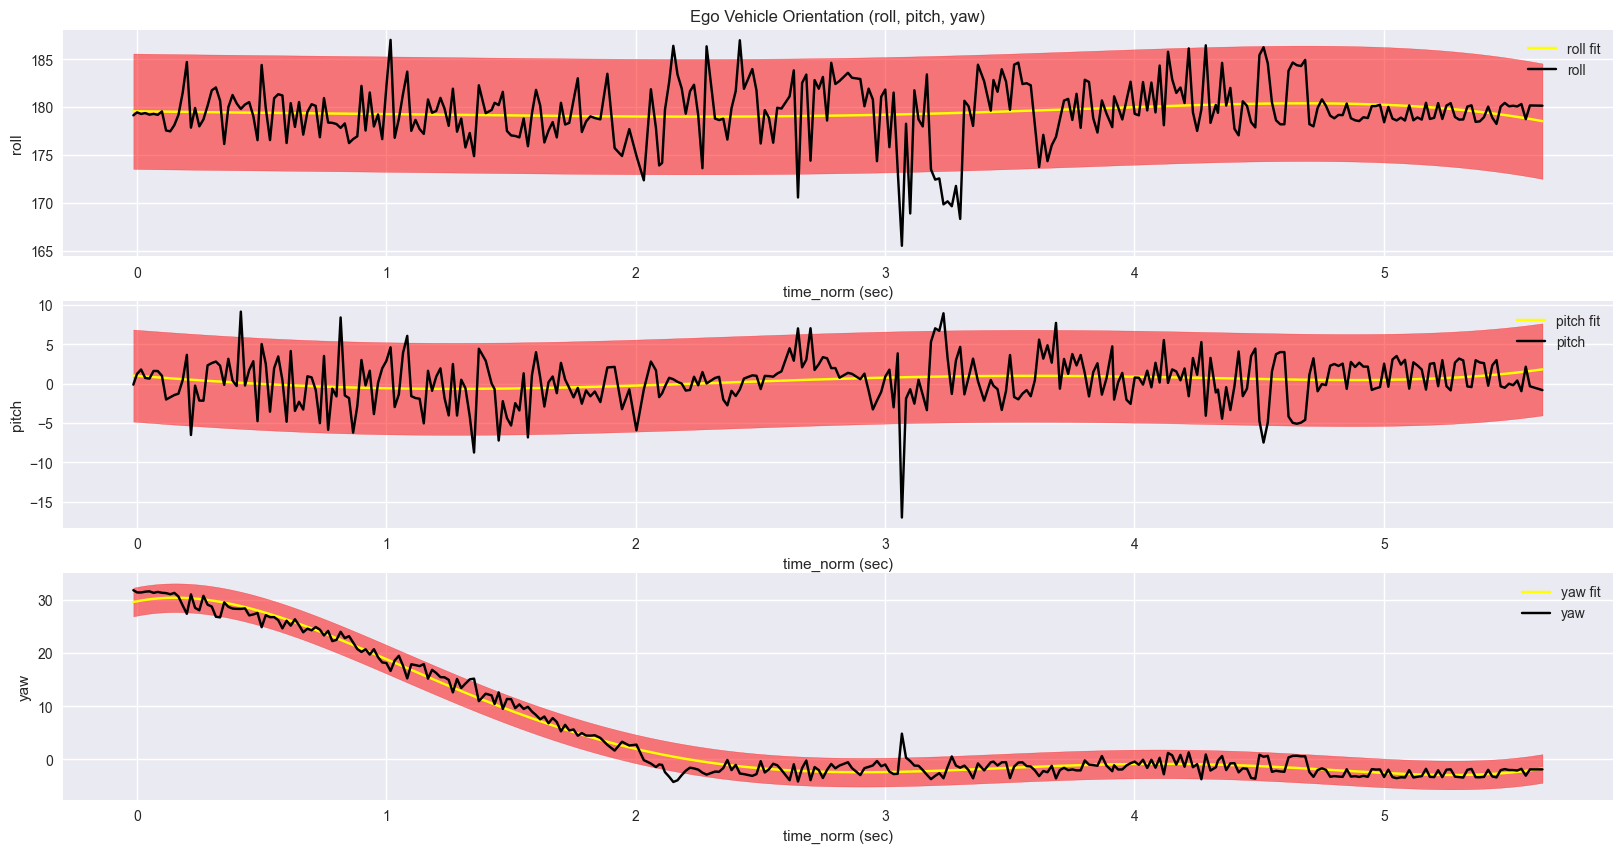

In [25]:
# plot the euler angles of ego_bev_df in the same way
degree = 5
roll_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['roll'], degree)
pitch_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['pitch'], degree)
yaw_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['yaw'], degree)

roll_preds = roll_model(ego_bev_right_df['time_norm (sec)'])
pitch_preds = pitch_model(ego_bev_right_df['time_norm (sec)'])
yaw_preds = yaw_model(ego_bev_right_df['time_norm (sec)'])

roll_residuals = ego_bev_right_df['roll'] - roll_preds
pitch_residuals = ego_bev_right_df['pitch'] - pitch_preds
yaw_residuals = ego_bev_right_df['yaw'] - yaw_preds

roll_se = np.sqrt(sum(roll_residuals ** 2) / (len(roll_residuals) - degree - 1))
pitch_se = np.sqrt(sum(pitch_residuals ** 2) / (len(pitch_residuals) - degree - 1))
yaw_se = np.sqrt(sum(yaw_residuals ** 2) / (len(yaw_residuals) - degree - 1))

z_score = stats.norm.ppf(1 - (1 - CONFIDENCE_INTERVAL) / 2)

roll_confidence = z_score * roll_se
pitch_confidence = z_score * pitch_se
yaw_confidence = z_score * yaw_se

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title('Ego Vehicle Orientation (roll, pitch, yaw)')
# plot the polynomial fit
plt.plot(ego_bev_right_df['time_norm (sec)'], roll_preds, label='roll fit', markersize='5', color='yellow')
# show the confidence interval
plt.fill_between(ego_bev_right_df['time_norm (sec)'], roll_preds - roll_confidence, 
                    roll_preds + roll_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='roll', label='roll', color='black')

plt.subplot(3, 1, 2)
plt.plot(ego_bev_right_df['time_norm (sec)'], pitch_preds, label='pitch fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_right_df['time_norm (sec)'], pitch_preds - pitch_confidence, 
                 pitch_preds + pitch_confidence, alpha=0.5, color='red')

sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='pitch', label='pitch', color='black')

plt.subplot(3, 1, 3)
plt.plot(ego_bev_right_df['time_norm (sec)'], yaw_preds, label='yaw fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_right_df['time_norm (sec)'], yaw_preds - yaw_confidence, 
                 yaw_preds + yaw_confidence, alpha=0.5, color='red')

sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='yaw', label='yaw', color='black')

[14] (-179.71281351074762, 2.458595967695903, -169.85645036179432) [[-2.73744360e-01]
 [ 3.08629021e+00]
 [-1.85703269e-03]] [-8.83294338e-02  9.95857107e-01 -5.99211051e-04  2.15910911e-02]
[14] (-134.68969626954555, 55.96906880913935, -145.39127304892753) [[-0.16783491]
 [ 1.99894285]
 [-0.47088507]] [-0.06984043  0.83181163 -0.19594741  0.51460309]

[12] (158.43355259893164, 9.813781746981347, -3.805198788224907) [[ 2.76038926]
 [-0.04653657]
 [-0.25430944]] [ 0.97873356 -0.01650017 -0.09016887  0.18351551]
[12] (165.50286128404443, -17.030486628259034, 4.854473684848058) [[2.86910695]
 [0.06692603]
 [0.44468096]] [0.98098373 0.02288285 0.15204201 0.11845052]

[15] (-64.99623289984291, -88.54791882395403, -107.49674377691919) [[-2.13270132]
 [-0.11520306]
 [-2.15242539]] [-0.70228582 -0.03793568 -0.70878084  0.05463737]
[15] (155.1945504407035, 25.82279860153013, -18.20896167056857) [[ 2.68909491]
 [-0.29300612]
 [-0.70551778]] [ 0.94756942 -0.10324799 -0.24860672  0.17218229]

[14]

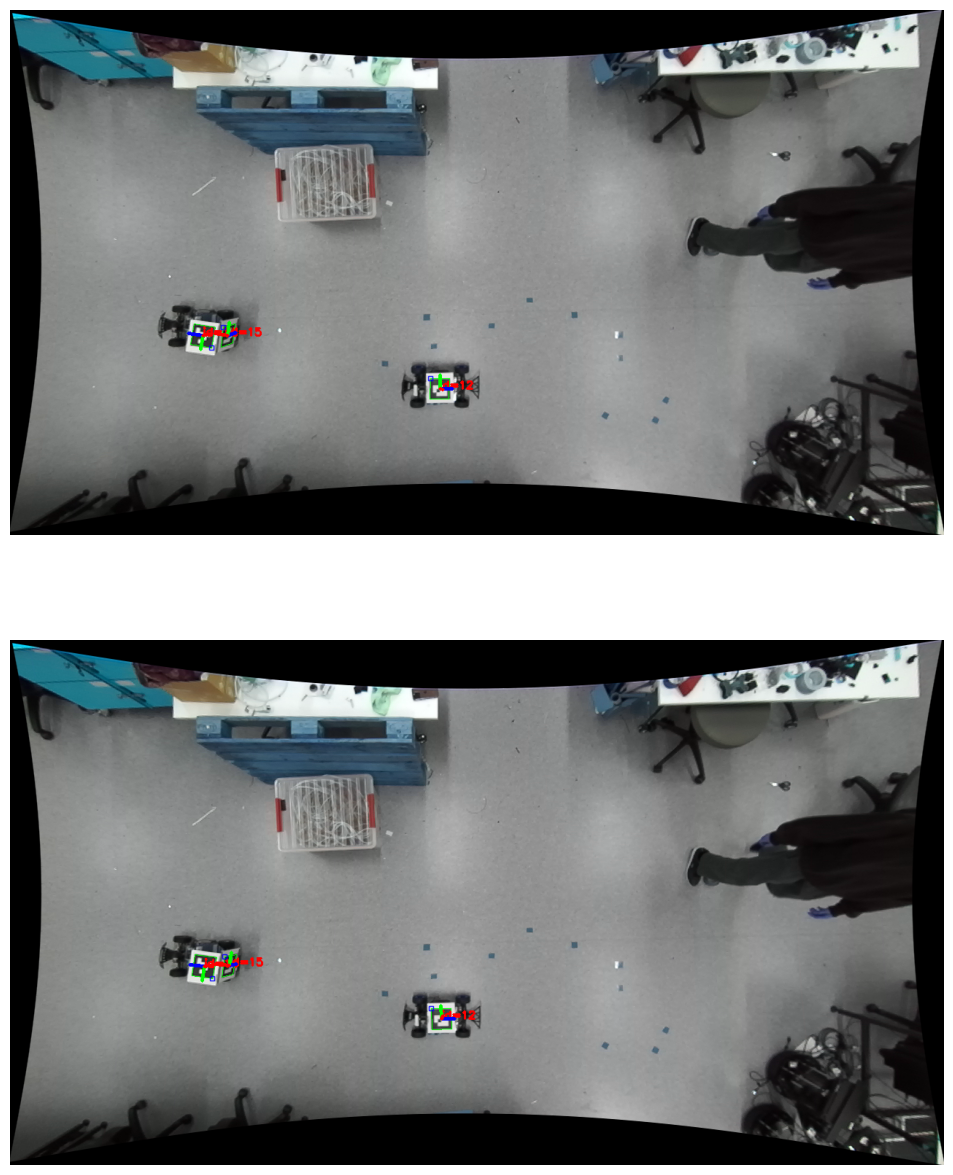

In [20]:
import perception.util.aruco as aruco

num = 174
image_prev = cv2.imread(f'{run1_data[run_num]["bev_path"]}/bev/right/{ego_bev_right_df["time"].iloc[num - 1]}.png')

image = cv2.imread(f'{run1_data[run_num]["bev_path"]}/bev/right/{ego_bev_right_df["time"].iloc[num]}.png')
# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

intrinsics = np.loadtxt(f'{run1_data[run_num]["bev_path"]}/bev/right/intrinsics.txt')
dist_coeffs = np.loadtxt(f'{run1_data[run_num]["bev_path"]}/bev/right/dist_coeffs.txt')

def draw_markers_on_image(image, intrinsics, dist_coeffs):
  new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
  undistorted_image = cv2.undistort(image, intrinsics, dist_coeffs, None, new_intrinsics)

  und_corners, und_ids, _ = cv2.aruco.detectMarkers(undistorted_image, dictionary, parameters=detector_params)

  drawn_image = cv2.aruco.drawDetectedMarkers(undistorted_image.copy(), und_corners, und_ids)

  for corner, id in zip(und_corners, und_ids):
    _, rvecs_und, tvecs_und, reproj_error = cv2.solvePnPGeneric(marker_obj_points, corner, new_intrinsics, None, flags=cv2.SOLVEPNP_IPPE_SQUARE)
    for rvec_und, tvec_und in zip(rvecs_und, tvecs_und):
      quat = conv.get_quaternion_from_rodrigues(rvec_und)
      euler_und = conv.get_euler_from_quaternion(*quat, degrees=True)
      print(id, euler_und, rvec_und, quat)
    
    print("")
    cv2.drawFrameAxes(drawn_image, new_intrinsics, None, rvec_und, tvec_und, 0.1)
  
  return drawn_image

drawn_image = draw_markers_on_image(image, intrinsics, dist_coeffs)
drawn_image_prev = draw_markers_on_image(image_prev, intrinsics, dist_coeffs)

plt.figure(figsize=(20, 15))
plt.subplot(2, 1, 1)
plt.grid(False)
plt.axis('off')
plt.imshow(drawn_image)

plt.subplot(2, 1, 2)
plt.grid(False)
plt.axis('off')
plt.imshow(drawn_image_prev)